## (1) Import libraries

In [1]:
from pycaret.datasets import get_data
from pycaret.internal.pycaret_experiment import TimeSeriesExperiment

from sktime.utils.plotting import plot_series

In [2]:
# Record version of key libraries
from importlib.metadata import version

print('pycaret==%s' % version('pycaret'))
print('pycaret-ts-alpha==%s' % version('pycaret-ts-alpha'))

pycaret==2.3.1
pycaret-ts-alpha==3.0.0.dev1624743408


## (2) Get data

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
Freq: M, Name: Number of airline passengers, dtype: float64

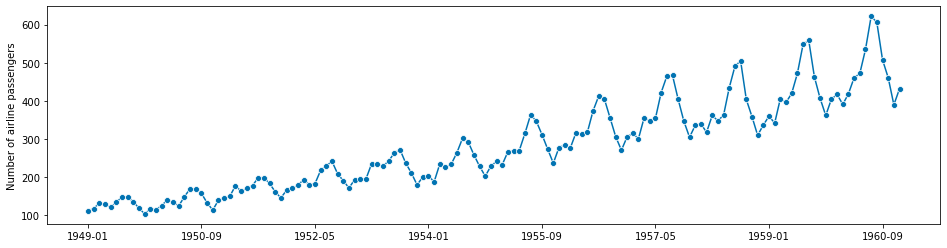

In [3]:
# Get a list of all pre-packaged data
# get_data('index') # NOTE - currently will not show time series sample data

# Select a pre-packaged data for testing
# NOTE - only support univariate currently
y_raw_data = get_data('airline')

# Plot time series
_ = plot_series(y_raw_data) # NOTE - will be bundled into pycaret interface

## (3) Setup pipeline

This step also includes data pre-processing steps such as normalisation and missing values imputation.

Logged data and profile are stored under `mlruns` folder.

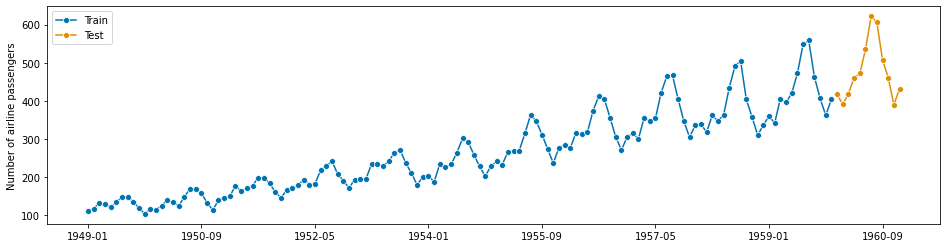

In [5]:
# Setup pycaret experiment object
exp = TimeSeriesExperiment()

# Setup core pycaret config
# NOTE - only support univariate currently
exp.setup(
    data=y_raw_data, 
    fh=12, 
    fold=3,
    fold_strategy='expanding',
    seasonal_period=12,
    imputation_type='simple',
    n_jobs=-1,
    preprocess=True,
    session_id=6, 
    log_data=True,
    log_profile=True,
    log_experiment=True, 
    experiment_name='airline1')

# Retrieve and save processed data 
y_data = exp.get_config('y')
y_data.to_csv('./processed_data.csv', index=False)

# data_processing_pipeline = exp.get_config('prep_pipe')

# Visualise train and test data split
y_train = exp.get_config("y_train")
y_test = exp.get_config("y_test")

_ = plot_series(y_train, y_test, labels=['Train', 'Test'])


## (4) Compare models

In [6]:
# Select a list of models of interest to be tested
# # To see all available models
# exp.models()

# Pick specific models
# chosen_model_types_list = ['lr'] + models(type='ensemble').index.tolist()

top3_models = exp.compare_models(
    n_select = 3,
    sort = 'MAE',
    errors='raise'
)

print(top3_models)

[AutoETS(additive_only=False, allow_multiplicative_trend=False, auto=False,
        bounds=None, callback=None, damped_trend=False, dates=None, disp=False,
        error='add', freq=None, full_output=True, information_criterion='aic',
        initial_level=None, initial_seasonal=None, initial_trend=None,
        initialization_method='estimated', maxiter=1000, missing='none',
        n_jobs=None, restrict=True, return_params=False, seasonal='add', sp=12,
        start_params=None, trend='add'), ExponentialSmoothing(damped_trend=False, initial_level=None,
                     initial_seasonal=None, initial_trend=None,
                     initialization_method='estimated', seasonal='add', sp=12,
                     trend='add', use_boxcox=None), ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 1, 0, 12),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)]


## (5) Tune models

In [7]:
# Tune top models
# NOTE - only support sklearn random and grid search now

tuned_top3_models = [
    exp.tune_model(
        i, 
        optimize='MAE',
        search_algorithm='random',
        choose_better=True
    ) 
    for i in top3_models]

print(tuned_top3_models)

[AutoETS(additive_only=False, allow_multiplicative_trend=False, auto=False,
        bounds=None, callback=None, damped_trend=False, dates=None, disp=False,
        error='add', freq=None, full_output=True, information_criterion='aic',
        initial_level=None, initial_seasonal=None, initial_trend=None,
        initialization_method='estimated', maxiter=1000, missing='none',
        n_jobs=None, restrict=True, return_params=False, seasonal='add', sp=12,
        start_params=None, trend='add'), ExponentialSmoothing(damped_trend=False, initial_level=None,
                     initial_seasonal=None, initial_trend=None,
                     initialization_method='estimated', seasonal='add', sp=12,
                     trend='add', use_boxcox=None), ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 1, 0, 12),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)]


## (6) Combine multiple models

In [9]:
# Blend top tuned models into a single voting regressor model

blended_model = exp.blend_models(
    estimator_list = tuned_top3_models
)

print(blended_model)

_EnsembleForecasterWithVoting(forecasters=[('ets',
                                            AutoETS(additive_only=False,
                                                    allow_multiplicative_trend=False,
                                                    auto=False, bounds=None,
                                                    callback=None,
                                                    damped_trend=False,
                                                    dates=None, disp=False,
                                                    error='add', freq=None,
                                                    full_output=True,
                                                    information_criterion='aic',
                                                    initial_level=None,
                                                    initial_seasonal=None,
                                                    initial_trend=None,
                                                    

## (7) Analyze model performance

In [11]:
# # Make interactive standard diagnostic plots
# # NOTE - not implemented yet
# exp.evaluate_model(blended_model)

# plot_model(blended_model, plot='residuals_interactive')
# plot_model(blended_model, plot='error')
# plot_model(blended_model, plot='learning')
# plot_model(blended_model, plot='manifold')
# # plot_model(blended_model, plot='feature')

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(), value=None), Output()),…

## (8) Check model prediction

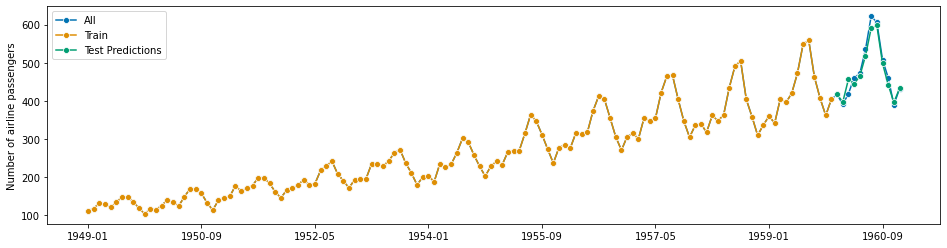

In [12]:
# Check model prediction

y_pred = exp.predict_model(blended_model)
_ = plot_series(y_raw_data, y_train, y_pred[0], labels=['All', 'Train', 'Test Predictions'])

## (9) Finalize model (i.e. train on full data)

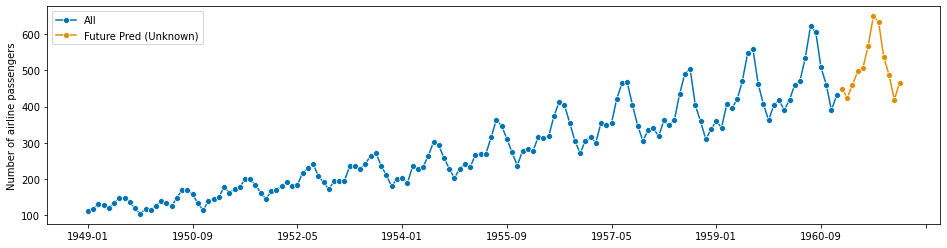

In [13]:
# Train on full dataset so that the model is ready to forecast future after that

final_model = exp.finalize_model(blended_model)

y_pred_future = exp.predict_model(final_model, verbose=False)
_ = plot_series(y_raw_data, y_pred_future[0], labels=['All', 'Future Pred (Unknown)'])



## (10) Save best model

In [16]:
# Save model

exp.save_model(final_model, model_name='best_model')
# final_model = exp.load_model('best_model')

Transformation Pipeline and Model Successfully Saved


(_EnsembleForecasterWithVoting(forecasters=[('ets',
                                             AutoETS(additive_only=False,
                                                     allow_multiplicative_trend=False,
                                                     auto=False, bounds=None,
                                                     callback=None,
                                                     damped_trend=False,
                                                     dates=None, disp=False,
                                                     error='add', freq=None,
                                                     full_output=True,
                                                     information_criterion='aic',
                                                     initial_level=None,
                                                     initial_seasonal=None,
                                                     initial_trend=None,
                                       